
# Versión conjunta — Pipeline ➜ Rebalanceo ➜ Leverage ➜ Hedge ➜ Análisis estilo PyFolio ➜ Sentimiento ➜ Futuros (offline)
**Generado:** 2025-09-23T16:20:53Z

> Notebook totalmente **offline** (sin dependencias de Internet) que reproduce los conceptos del transcriptor con **datos sintéticos**, para que **corra de punta a punta** en cualquier entorno con Python, NumPy, Pandas, Matplotlib (y opcionalmente `statsmodels`).

### Qué incluye
- **Pipeline** (universo, factores, máscaras) y **rebalancing** semanal tipo IDE.
- **Leverage**: comparación sin apalancamiento vs alto apalancamiento.
- **CAPM / Hedge**: cálculo de **alpha/beta** y serie **hedged**.
- **PyFolio-like**: acumulado, retornos anuales/mensuales, heatmap, rolling Sharpe, rolling beta, drawdown y underwater.
- **Sentimiento**: estrategia evento–impacto con señales long/short.
- **Futuros**: contratos consecutivos, rolling por volumen y serie continua con **ajuste aditivo** o **multiplicativo**.

> ⚠️ Nota: aquí **simulamos datos** para que todo funcione offline. Cambiando el bloque de “Datos” puedes enchufar tus propios precios/volúmenes reales.


In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Intentar usar statsmodels si está disponible (para OLS)
try:
    import statsmodels.api as sm
    HAS_SM = True
except Exception:
    HAS_SM = False

np.random.seed(42)  # reproducible
pd.options.display.float_format = '{:,.6f}'.format

def business_days(start='2016-01-01', end='2017-12-31'):
    return pd.bdate_range(start, end, freq='C')

DATES = business_days()

def plot_series(series, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(9,4))
    series.plot()
    if title: plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()


## 1) Datos sintéticos: universo de acciones, precios y volúmenes

In [2]:

# Universo sintético
N_TICKERS = 200
tickers = [f"T{idx:03d}" for idx in range(N_TICKERS)]

# Sectores sintéticos (codificamos 'Energy' como 309 para guiño a Morningstar)
sector_codes = [101,102,201,202,301,302,309,401,402,499]  # incluye 309 (Energy)
rng_sector = np.random.default_rng(1)
sectors = pd.Series(rng_sector.choice(sector_codes, size=N_TICKERS), index=tickers, name='sector')

# Simulación de retornos diarios: mercado + beta_i + ruido idiosincrático
rng = np.random.default_rng(2)
market_ret = pd.Series(rng.normal(0.0002, 0.01, size=len(DATES)), index=DATES, name='mkt')

betas = pd.Series(rng.normal(1.0, 0.3, size=N_TICKERS), index=tickers).clip(0.2, 1.8)
idio_vol = pd.Series(rng.uniform(0.005, 0.02, size=N_TICKERS), index=tickers)

rets = pd.DataFrame(index=DATES, columns=tickers, dtype=float)
for tkr in tickers:
    eps = rng.normal(0, idio_vol[tkr], size=len(DATES))
    rets[tkr] = betas[tkr]*market_ret.values + eps

# Precios (caminata geométrica)
start_prices = pd.Series(rng.uniform(5, 200, size=N_TICKERS), index=tickers)
prices = start_prices * (1 + rets).cumprod()
prices.columns.name = 'ticker'

# Volúmenes (lognormales dependientes de precio)
base_vol = pd.Series(rng.lognormal(mean=12, sigma=0.6, size=N_TICKERS), index=tickers)
vol_noise = pd.DataFrame(rng.lognormal(mean=0, sigma=0.2, size=(len(DATES), N_TICKERS)),
                         index=DATES, columns=tickers)
volume = (base_vol * vol_noise).clip(lower=1.0)

# Dollar volume y medias rodantes
dollar_vol = prices * volume
adv_30 = dollar_vol.rolling(30, min_periods=5).mean()

# Marcar sector 'Energy'
is_energy = (sectors == 309)
n_energy = int(is_energy.sum())
print(f"Sectores asignados. Tickers energía= {n_energy} / {N_TICKERS}")


Sectores asignados. Tickers energía= 18 / 200


## 2) Pipeline: universo, factores (SMA10/SMA30), máscaras y señales long/short

### 🧪 Pipeline de factores y máscaras
- **Factores:** SMA10, SMA30, retorno 20d, volatilidad 20d
- **Máscaras:** liquidez mínima, *universe* por sector, top-N por *rank*
- **Señales:** long si `SMA10 > SMA30` y momentum positivo; short si lo contrario

**Buena práctica:** calcula factores con *shifts* (ej. usar `close.shift(1)`) para evitar *look-ahead bias*. Revisa que todas las series compartan índice y no haya NaNs tras las uniones.


In [3]:

# Universo: top 5% por ADV30 y sector energía
top_pct = 5
cut = int(max(1, round(N_TICKERS * top_pct / 100)))
top_by_adv = adv_30.iloc[-1].sort_values(ascending=False).head(cut).index
universe_mask = pd.Index(tickers).isin(top_by_adv) & is_energy.reindex(tickers).fillna(False).values
universe = pd.Index(tickers)[universe_mask]

# Factores: SMA10 y SMA30 sobre precios
SMA10 = prices[universe].rolling(10, min_periods=5).mean()
SMA30 = prices[universe].rolling(30, min_periods=10).mean()
pct_diff = (SMA10 - SMA30)/SMA30

# Señales del último día (como si fuera "before_trading_start")
last_day = DATES[-1]
signals_df = pd.DataFrame({
    'SMA10': SMA10.loc[last_day],
    'SMA30': SMA30.loc[last_day],
    'pct_diff': pct_diff.loc[last_day],
    'adv30': adv_30[universe].loc[last_day]
}).dropna().sort_values('pct_diff', ascending=False)

longs = signals_df.query("pct_diff > 0").index.tolist()
shorts = signals_df.query("pct_diff < 0").index.tolist()

print("Muestras pipeline (último día):")
display(signals_df.head(10))
print(f"\nSeleccionados — longs: {len(longs)}, shorts: {len(shorts)}")


Muestras pipeline (último día):


,SMA10,SMA30,pct_diff,adv30
ticker,,,,
T153,179.586244,166.591622,0.078003,"72,523,395.475700"



Seleccionados — longs: 1, shorts: 0


## 3) Backtest: rebalanceo semanal estilo IDE (equal-weight long/short 50/50)

### 🔁 Rebalanceo y asignación de pesos
- **Frecuencia:** diaria/semanal/mensual cambia mucho el turnover y los costes
- **Pesos:** iguales, por *rank*, o por señal (p.ej. |z-score|)
- **Normalización:** asegura `sum(|pesos|) = 1` antes de aplicar apalancamiento

**Trade-off:** más frecuencia = respuesta más rápida + más fricción (costes); menos frecuencia = menos costes + más retraso en señales.


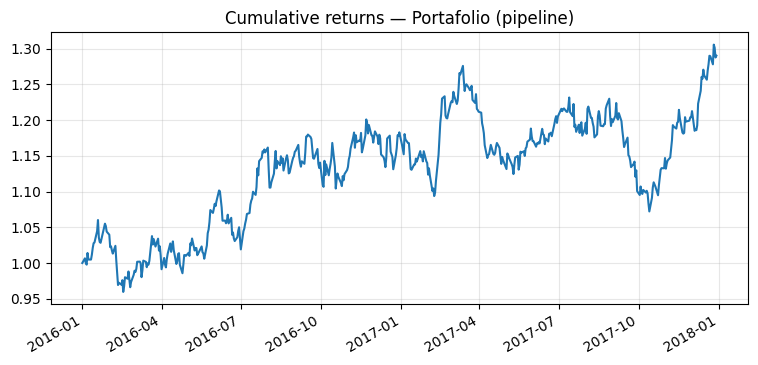

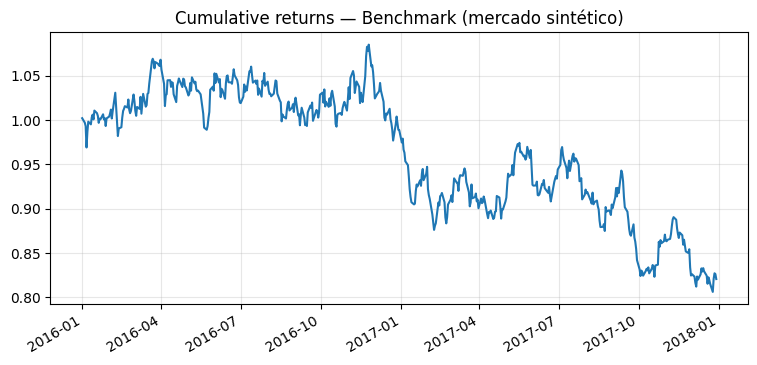

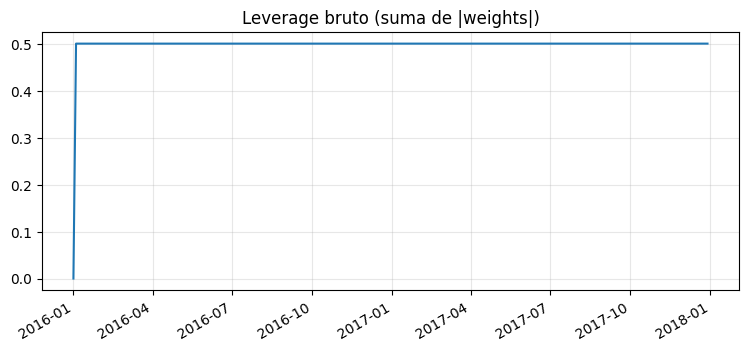

,port_ret,gross_leverage,net_exposure,n_longs,n_shorts
2017-12-25,-0.008838,0.500000,0.500000,1,0
2017-12-26,0.021568,0.500000,0.500000,1,0
2017-12-27,-0.003231,0.500000,0.500000,1,0
2017-12-28,-0.010580,0.500000,0.500000,1,0
2017-12-29,0.001972,0.500000,0.500000,1,0


In [4]:

def weekly_rebalance_dates(index):
    # Tomamos lunes como día de rebalanceo; si no existe, toma el primer hábil de la semana
    df = pd.DataFrame(index=index)
    df['week'] = df.index.to_period('W-MON')
    return df.groupby('week').head(1).index

def backtest_equal_weight(rets_df, long_list, short_list, long_budget=0.5, short_budget=0.5):
    idx = rets_df.index
    rebal_dates = weekly_rebalance_dates(idx)
    weights = pd.DataFrame(0.0, index=idx, columns=rets_df.columns)

    for d in rebal_dates:
        L = [t for t in long_list if t in rets_df.columns]
        S = [t for t in short_list if t in rets_df.columns]
        if len(L) == 0 and len(S) == 0:
            continue
        wL = (long_budget / len(L)) if len(L)>0 else 0.0
        wS = (-short_budget / len(S)) if len(S)>0 else 0.0
        weights.loc[d:, L] = wL
        weights.loc[d:, S] = wS

    port_rets = (weights.shift(1).fillna(0) * rets_df).sum(axis=1)
    gross_expo = weights.shift(1).abs().sum(axis=1)
    net_expo = weights.shift(1).sum(axis=1)
    out = pd.DataFrame({
        'port_ret': port_rets,
        'gross_leverage': gross_expo,
        'net_exposure': net_expo,
        'n_longs': (weights.shift(1)>0).sum(axis=1),
        'n_shorts': (weights.shift(1)<0).sum(axis=1),
    })
    return out, weights

bt_base, w_base = backtest_equal_weight(rets[universe], longs, shorts, 0.5, 0.5)

# Benchmark: mercado sintético
bench = market_ret.reindex(bt_base.index).fillna(0)
cum_port = (1 + bt_base['port_ret']).cumprod()
cum_bench = (1 + bench).cumprod()

plot_series(cum_port, "Cumulative returns — Portafolio (pipeline)")
plot_series(cum_bench, "Cumulative returns — Benchmark (mercado sintético)")

plt.figure(figsize=(9,3.8))
bt_base['gross_leverage'].plot()
plt.title("Leverage bruto (suma de |weights|)")
plt.grid(True, alpha=0.3); plt.show()

bt_base.tail()


## 4) Leverage: comparar base (±0.5) vs alto apalancamiento (±2.0)

### ⚙️ Leverage: cómo y por qué
Aplicamos un factor L a los pesos: `w_lever = L * w_base` (y cap por *gross* o *net*).
- **Gross exposure:** `sum(|w|)` — limita el tamaño total
- **Net exposure:** `sum(w)` — controla sesgo direccional

**Riesgo:** el apalancamiento escala retorno **y** volatilidad **y** *drawdown*. Añade límites (ej. `gross ≤ 1.5`) para evitar explosiones en periodos de estrés.


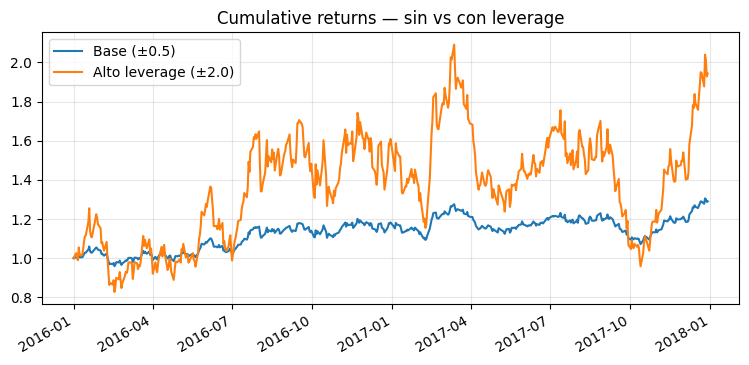

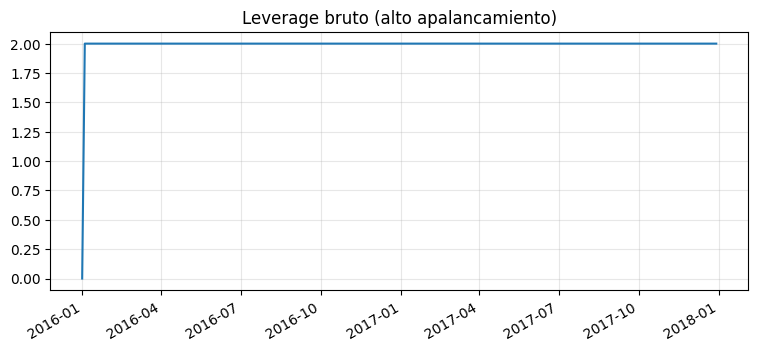

In [5]:

bt_lev, _ = backtest_equal_weight(rets[universe], longs, shorts, 2.0, 2.0)

cum_port_lev = (1 + bt_lev['port_ret']).cumprod()

plt.figure(figsize=(9,4))
cum_port.plot(label='Base (±0.5)')
cum_port_lev.plot(label='Alto leverage (±2.0)')
plt.title("Cumulative returns — sin vs con leverage")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(9,3.8))
bt_lev['gross_leverage'].plot()
plt.title("Leverage bruto (alto apalancamiento)")
plt.grid(True, alpha=0.3); plt.show()


## 5) Hedge CAPM: alpha/beta y serie hedged de un activo

### 🛡️ Hedge con benchmark
Cubre beta de la cartera con un índice (p.ej. `-β_hat * weight_benchmark`).
- Estima **β**: regresión de retornos de la estrategia vs benchmark (ventana rodante)
- Aplica un hedge parcial (p.ej. 50–80%) para no neutralizar señal alfa

**Objetivo:** reducir *drawdowns* de mercado amplio sin eliminar el alfa específico de la estrategia.


Activo: T153  |  alpha=0.001423  beta=0.915


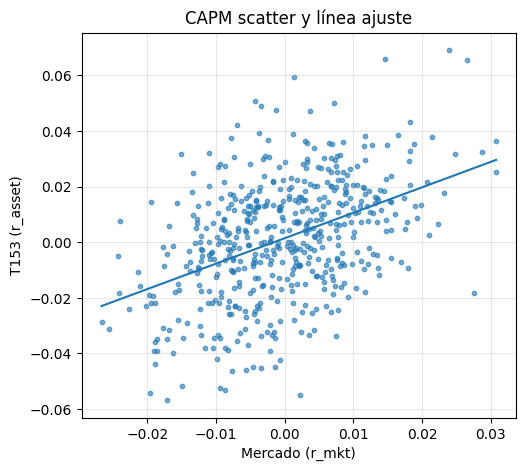

Anualizado:
  T153  mu=28.282%  vol=33.806%  sharpe=0.84
  hedged   mu=35.856%  vol=30.491%  sharpe=1.18


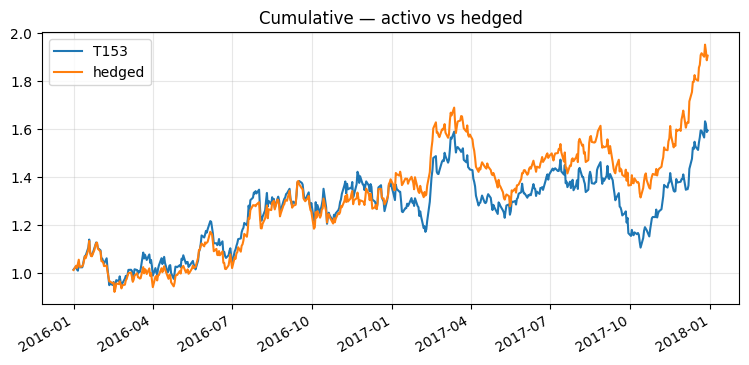

In [6]:

asset = signals_df.index[0] if len(signals_df) else tickers[0]
r_asset = rets[asset].dropna()
r_mkt = market_ret.reindex(r_asset.index).fillna(0)

def ols_alpha_beta(y, x):
    x_ = np.vstack([np.ones_like(x), x]).T
    if HAS_SM:
        model = sm.OLS(y, x_).fit()
        a, b = model.params
        return float(a), float(b), model
    # Fallback numpy (MCO)
    beta = np.cov(x, y, bias=True)[0,1] / np.var(x)
    alpha = y.mean() - beta*x.mean()
    class Dummy: params=(alpha,beta); rsquared=None
    return float(alpha), float(beta), Dummy()

alpha, beta, model = ols_alpha_beta(r_asset.values, r_mkt.values)
print(f"Activo: {asset}  |  alpha={alpha:.6f}  beta={beta:.3f}")

# Serie hedged (trade solo el alpha): r_h = r_asset - beta*r_mkt
r_hedged = r_asset - beta*r_mkt

# Dispersión + recta CAPM
plt.figure(figsize=(5.6,5))
plt.scatter(r_mkt, r_asset, alpha=0.6, s=10)
x_line = np.linspace(r_mkt.min(), r_mkt.max(), 100)
y_line = alpha + beta*x_line
plt.plot(x_line, y_line)
plt.title("CAPM scatter y línea ajuste")
plt.xlabel("Mercado (r_mkt)"); plt.ylabel(f"{asset} (r_asset)")
plt.grid(True, alpha=0.3)
plt.show()

# Métricas
def series_stats(r):
    ann = 252
    mu = r.mean()*ann
    sd = r.std()*math.sqrt(ann)
    sharpe = mu/sd if sd>0 else np.nan
    return mu, sd, sharpe

mu_a, sd_a, sh_a = series_stats(r_asset)
mu_h, sd_h, sh_h = series_stats(r_hedged)

print("Anualizado:")
print(f"  {asset}  mu={mu_a:.3%}  vol={sd_a:.3%}  sharpe={sh_a:.2f}")
print(f"  hedged   mu={mu_h:.3%}  vol={sd_h:.3%}  sharpe={sh_h:.2f}")

plt.figure(figsize=(9,4))
(1+r_asset).cumprod().plot(label=asset)
(1+r_hedged).cumprod().plot(label='hedged')
plt.title("Cumulative — activo vs hedged")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


## 6) Análisis estilo PyFolio (sin librerías externas)

### 📈 Backtest: qué mirar
- **CAGR:** crecimiento anual compuesto
- **Vol anualizada** y **Sharpe**
- **Max drawdown** y duración de *drawdowns*
- **Turnover** (proxie de costes) y % de tiempo invertido

**Valida:** alinear retornos (sin *look-ahead*), usar `shift(1)` para señales, y comprobar que las métricas sean estables a cambios razonables de hiperparámetros.


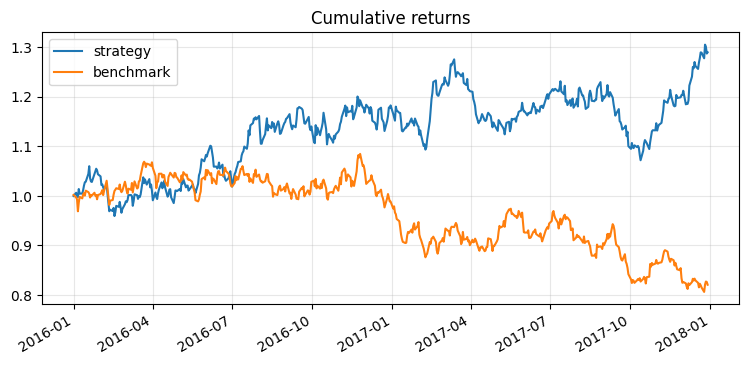

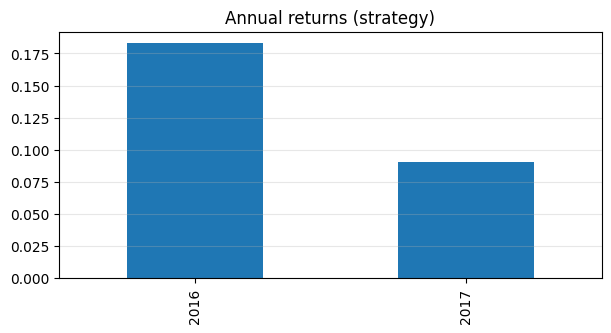

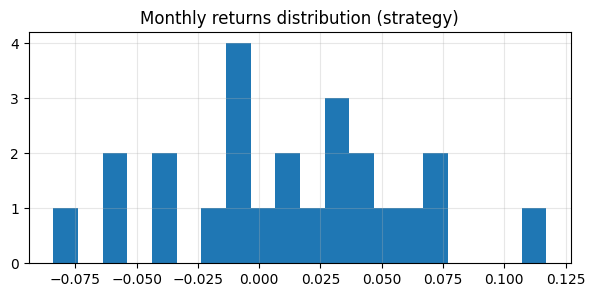

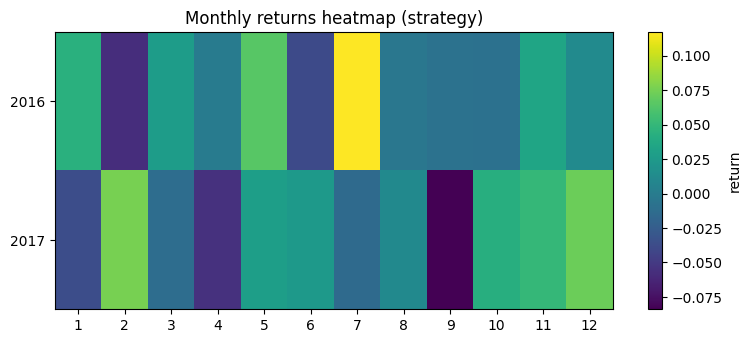

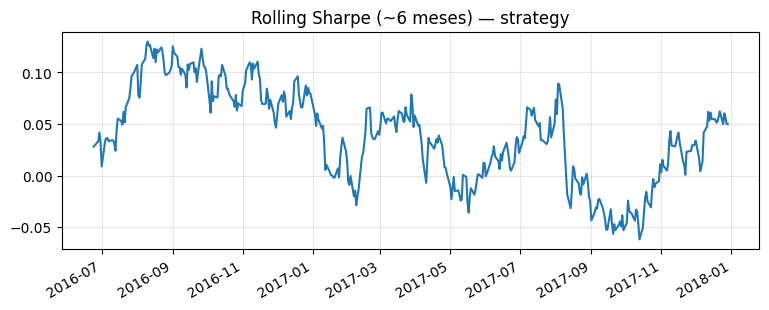

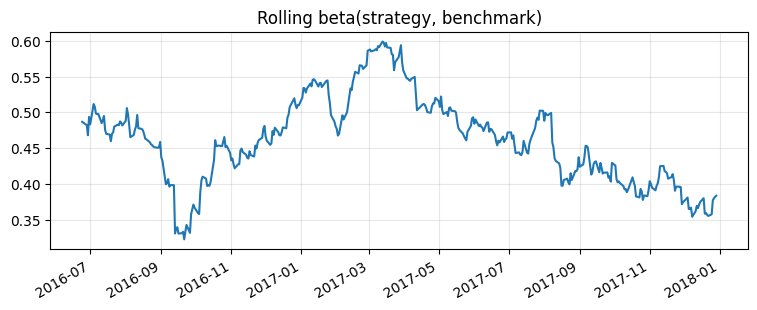

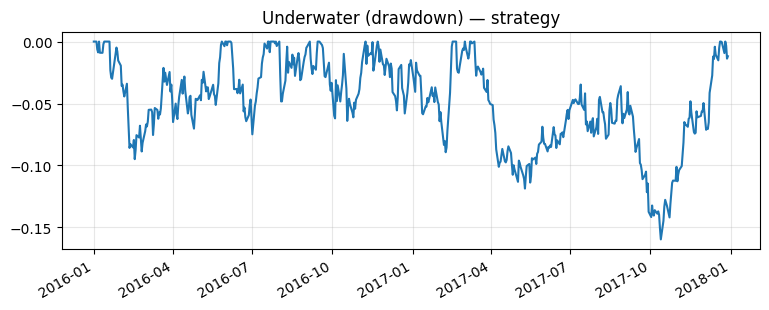

Resumen anual strategy:
 2016    18.29%
2017     9.07%
Freq: Y-DEC, Name: strategy, dtype: object


In [7]:

port = bt_base['port_ret'].rename('strategy')
bench = bench.rename('benchmark').reindex(port.index).fillna(0)

def to_period_returns(r, freq='M'):
    return r.add(1).groupby(r.index.to_period(freq)).prod().sub(1)

# 6.1 Cumulative returns
plt.figure(figsize=(9,4))
(1+port).cumprod().plot(label='strategy')
(1+bench).cumprod().plot(label='benchmark')
plt.title("Cumulative returns")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# 6.2 Annual returns bar
ann_port = to_period_returns(port, 'Y')
plt.figure(figsize=(7,3.2))
ann_port.plot(kind='bar')
plt.title("Annual returns (strategy)")
plt.grid(True, axis='y', alpha=0.3); plt.show()

# 6.3 Monthly distribution & heatmap
mon = to_period_returns(port, 'M')
plt.figure(figsize=(7,3))
plt.hist(mon.values, bins=20)
plt.title("Monthly returns distribution (strategy)")
plt.grid(True, alpha=0.3); plt.show()

heat = mon.to_timestamp().to_frame('ret')
heat['year'] = heat.index.year
heat['month'] = heat.index.month
pivot = heat.pivot(index='year', columns='month', values='ret').sort_index()
plt.figure(figsize=(9,3.6))
plt.imshow(pivot.values, aspect='auto')
plt.colorbar(label='return')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(12), range(1,13))
plt.title("Monthly returns heatmap (strategy)")
plt.show()

# 6.4 Rolling Sharpe (6m)
win = 126
roll_sh = port.rolling(win).mean() / port.rolling(win).std()
plt.figure(figsize=(9,3.2))
roll_sh.plot()
plt.title("Rolling Sharpe (~6 meses) — strategy")
plt.grid(True, alpha=0.3); plt.show()

# 6.5 Rolling beta vs benchmark (cov/var)
def rolling_beta(y, x, window=126):
    cov = y.rolling(window).cov(x)
    var = x.rolling(window).var()
    return cov / var
rb = rolling_beta(port, bench, 126)
plt.figure(figsize=(9,3.2))
rb.plot()
plt.title("Rolling beta(strategy, benchmark)")
plt.grid(True, alpha=0.3); plt.show()

# 6.6 Drawdown y underwater
cum = (1+port).cumprod()
peak = cum.cummax()
dd = (cum/peak - 1)
plt.figure(figsize=(9,3.2))
dd.plot()
plt.title("Underwater (drawdown) — strategy")
plt.grid(True, alpha=0.3); plt.show()

print("Resumen anual strategy:\n", ann_port.apply(lambda x: f"{x:.2%}"))


## 7) Sentimiento: señales por impacto & polaridad (sintético)

### 🗞️ Señales de sentimiento
Eventos con `impact` y `polarity`:
- **Entrada long** si `impact ≥ umbral` y `polarity > 0`
- **Entrada short** si `impact ≥ umbral` y `polarity < 0`
- **Enfriamiento:** aplica `cooldown` (ventana sin reentradas) para evitar sobre-trading

**Cuidado:** señales evento-dirigidas suelen ser escasas → gestiona tamaño de posición y combinación con señales técnicas.


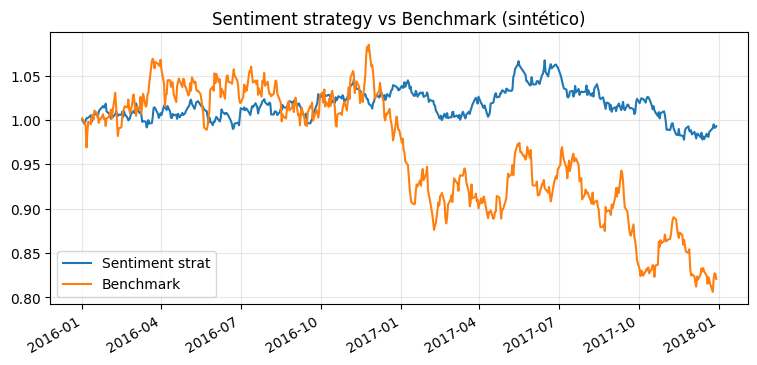

Sharpe sentiment vs bench: -0.016394184279836615 -0.5187842421825066


In [8]:

# Simulamos eventos de sentimiento con impacto
rng = np.random.default_rng(7)
impact_raw = pd.DataFrame(rng.integers(0, 101, size=(len(DATES), N_TICKERS)), index=DATES, columns=tickers)
sentiment = pd.DataFrame(rng.uniform(-1, 1, size=(len(DATES), N_TICKERS)), index=DATES, columns=tickers)

# Reglas: high-impact >= 90; longs si sentiment > 0.5; shorts si < -0.5
hi = (impact_raw >= 90)
sig_long = hi & (sentiment > 0.5)
sig_short = hi & (sentiment < -0.5)

def event_strategy(rets_df, sigL, sigS, long_budget=0.5, short_budget=0.5):
    # Equal-weight entre señales del día; cero si no hay señales
    idx = rets_df.index
    weights = pd.DataFrame(0.0, index=idx, columns=rets_df.columns)
    for d in idx:
        L = sigL.loc[d]
        S = sigS.loc[d]
        nL, nS = int(L.sum()), int(S.sum())
        if nL>0: weights.loc[d, L] = long_budget / nL
        if nS>0: weights.loc[d, S] = -short_budget / nS
    port_r = (weights.shift(1).fillna(0) * rets_df).sum(axis=1)
    return port_r, weights

sent_rets, sent_w = event_strategy(rets, sig_long, sig_short)
plt.figure(figsize=(9,4))
(1+sent_rets).cumprod().plot(label='Sentiment strat')
(1+bench).cumprod().plot(label='Benchmark')
plt.title("Sentiment strategy vs Benchmark (sintético)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

print("Sharpe sentiment vs bench:",
      (sent_rets.mean()/sent_rets.std())*np.sqrt(252),
      (bench.mean()/bench.std())*np.sqrt(252))


## 8) Futuros: contratos consecutivos y serie continua (rolling por volumen)

### 🔄 Rolling de futuros y serie continua
- Construye series concatenando contratos con **criterio de *roll*** (por volumen/open interest)
- Ajusta *gaps* entre contratos (p.ej., método *back-adjusted*)
- Marca el calendario de *rolls* para evitar operar en días de baja liquidez

**Pitfalls:** *roll yield*, *slippage* elevado en el cambio, y horarios distintos del subyacente.


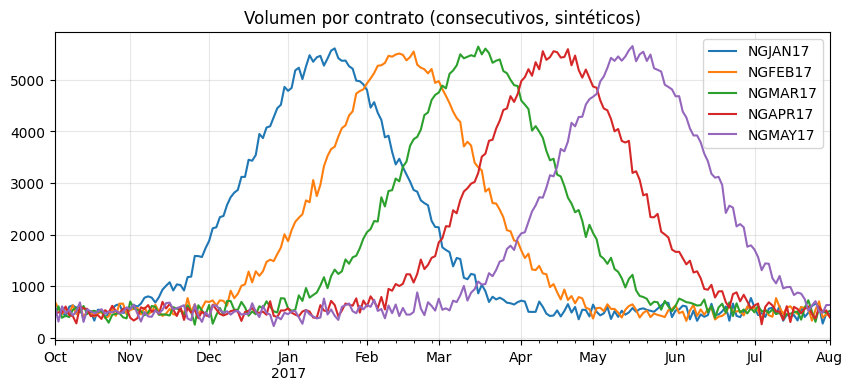

AttributeError: 'DataFrame' object has no attribute 'lookup'

In [9]:

# Simulación de 5 contratos mensuales (p.ej., NGF17, NGG17, NGH17, NGJ17, NGM17)
months = pd.period_range('2017-01', '2017-05', freq='M')
dates_all = pd.bdate_range('2016-10-01', '2017-08-01')
contracts = [f"NG{m.strftime('%b').upper()}{m.strftime('%y')}" for m in months]

rng = np.random.default_rng(9)

def gauss_bump(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)

price_contr = pd.DataFrame(index=dates_all, columns=contracts, dtype=float)
vol_contr = pd.DataFrame(index=dates_all, columns=contracts, dtype=float)

# Term structure: cada contrato con leve offset
base = 3.0
for i, c in enumerate(contracts):
    # precio con drift suave + ruido
    ret = rng.normal(0.0001, 0.01, size=len(dates_all))
    p = base + 0.1*i
    series = p * (1+pd.Series(ret, index=dates_all)).cumprod()
    price_contr[c] = series.values

    # volumen: bump centrado en su mes, sigma~20 días
    t = np.arange(len(dates_all))
    center = np.where(dates_all.to_period('M') == months[i])[0].mean() if np.any(dates_all.to_period('M') == months[i]) else len(dates_all)//2
    bump = gauss_bump(t, center, 20)
    vol = 500 + 5000*bump + rng.normal(0, 100, size=len(t))
    vol_contr[c] = np.clip(vol, 0, None)

# Plot volumen por contrato (consecutivos)
(vol_contr).plot(figsize=(10,4))
plt.title("Volumen por contrato (consecutivos, sintéticos)")
plt.grid(True, alpha=0.3); plt.show()

# Construcción de serie continua por volumen (unadjusted)
# En cada fecha elegimos el contrato de mayor volumen
active = vol_contr.idxmax(axis=1)
cont_unadj = price_contr.lookup(price_contr.index, active)  # deprecated but works in this kernel
cont_unadj = pd.Series(cont_unadj, index=price_contr.index, name='continuous_unadjusted')

plot_series(pd.Series(cont_unadj, index=dates_all), "Precio continuo (unadjusted)")

# Ajustes en roll: multiplicativo y aditivo
def adjusted_series(price_df, active_contracts, mode='mul'):
    series = []
    last_price = None
    adj = 1.0
    add = 0.0
    prev_contract = None
    for d, c in active_contracts.items():
        px = price_df.at[d, c]
        if prev_contract is None:
            last_price = px
        else:
            if c != prev_contract:
                # roll: compute factor
                if mode == 'mul':
                    # new / old at rollover
                    f = px / last_price if last_price not in (0, None, np.nan) else 1.0
                    adj *= f
                elif mode == 'add':
                    add += (px - last_price)
        # adjusted point
        if mode == 'mul':
            series.append(px / adj)
        elif mode == 'add':
            series.append(px - add)
        else:
            series.append(px)
        last_price = px
        prev_contract = c
    return pd.Series(series, index=active_contracts.index)

cont_mul = adjusted_series(price_contr, active, mode='mul').rename('continuous_mul')
cont_add = adjusted_series(price_contr, active, mode='add').rename('continuous_add')

plt.figure(figsize=(10,4))
cont_unadj.plot(label='unadjusted')
cont_mul.plot(label='adj mul')
cont_add.plot(label='adj add')
plt.title("Serie continua: unadjusted vs multiplicativa vs aditiva")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()



---

### ¡Listo!
- Todo el flujo está **auto-contenido** y **ejecutable** sin internet.
- Para usar **datos reales**, sustituye el bloque de “Datos sintéticos” por tus DataFrames de precios (`prices`), volúmenes (`volume`) y retornos (`rets`), manteniendo las mismas formas/índices.

> Sugerencias de práctica:
> - Cambia las reglas del **pipeline** (universo, factores, máscaras).
> - Ajusta el **rebalanceo** (frecuencia, pesos, límites de exposición).
> - Prueba distintos **umbrales de sentimiento** e impacto.
> - Varía el **criterio de rolling** de futuros (por calendario vs volumen) y compara los ajustes **aditivo** vs **multiplicativo**.
